# Measuring the finacial performance of real-estate assets.
## Part 1. Returns

In this three part series I'm going to be looking at how we can use data science to measure the finacial performance of real-estate (property) assets. I'll be introducing concepts from high finance (alpha $\alpha$ in part 2. and beta $\beta$ in part 3.), but adapting them for everyday use. In part 1. I first clean and prepare the [Land Registry](http://landregistry.data.gov.uk/) transaction data and explore the distribution of returns (pre-tax profits) we can expect form the UK housing market.

## 1.0 Land Registry - Prices Paid database

I download the 'Prices Paid' data as a .CSV file from http://landregistry.data.gov.uk/. Here you can download the full dataset, but its 3+GB. For convinience I limit my sample to properties bought and sold in 2016. Below in the Land Registry's description of what is included. Each element on the list below corresponds to a column in the data file.

1. **Transaction unique identifier** - A reference number which is generated automatically recording each published sale. The number is unique and will change each time a sale is recorded.

2. **Price** - Sale price stated on the transfer deed.

3. **Date of Transfer** - Date when the sale was completed, as stated on the transfer deed.

4. **Postcode** - This is the postcode used at the time of the original transaction. Note that postcodes can be reallocated and these changes are not reflected in the Price Paid Dataset.

5. **Property Type** - Note that they do not separately identify bungalows. End-of-terrace properties are included in the Terraced category. ‘Other’ is only valid where the transaction relates to a property type that is not covered by existing values.
    * D = Detached
    * S = Semi-Detached
    * T = Terraced
    * F = Flats/Maisonettes
    * O = Other 

6. **Old/New**	Indicates the age of the property and applies to all price paid transactions, residential and non-residential.
    * Y = a newly built property
    * N = an established residential building
7. **Duration**	Relates to the tenure: 
    * F = Freehold
    * L= Leasehold
Note that Land Registry does not record leases of 7 years or less in the Price Paid Dataset.

8. **PAON,	Primary Addressable Object Name.** If there is a sub-building for example the building is divided into flats, see Secondary Addressable Object Name (SAON).

9. **SAON	Secondary Addressable Object Name.** If there is a sub-building, for example the building is divided into flats, there will be a SAON.

10. **Street**

11. **Locality**

12. **Town/City**

13. **District** 

14. **County**	 

15. **PPD Category Type** - Indicates the type of Price Paid transaction. Note that category B does not separately identify the transaction types stated. Land Registry has been collecting information on Category A transactions from January 1995. Category B transactions were identified from October 2013
    * A = Standard Price Paid entry, includes single residential property sold for full market value.
    * B = Additional Price Paid entry including transfers under a power of sale/repossessions, buy-to-lets (where they can be identified by a Mortgage) and transfers to non-private individuals..

16. **Record Status** - Monthly file only. Indicates additions, changes and deletions to the records.(see guide below).
    * A = Addition
    * C = Change
    * D = Delete.


## 1.1 Cleaning the data

First, I load up the .CSV file into pandas.

In [1]:
import pandas as pd              # pandas dataframe lib
import datetime as dt            # datetime lib for handling dates
import matplotlib.pyplot as plt  # matplotlib for plots and graphs
import seaborn.apionly as sns    # seaborn for nicer looking plots
sns.set()

df = pd.read_csv(open('pp-2016-part1.csv','rb')) # read the .csv file
cols = ['transaction_id','sale_price','sale_date','postcode','type','new_build','lease','PAON','SAON','street',
        'locality','town','district','county','trans_type','record_type']
df.columns = [cols] # rename the columns to be more readable

There are quite a few columns that we are not going to need for this analysis, so we can use .drop to get rid of them stright away.

In [2]:
# drop unused cols
df = df.drop(['town','county','trans_type','record_type','locality',
                            'new_build','lease','district','street','transaction_id'], axis=1)
df.shape # number of rows and cols

(411901, 6)

Each of the ~400,000 entries relates to a specific transaction, and not a specific property. So I create a way to identify each unique property based on the house number (['PAON'] and ['SAON']) and ['postcode']. I then filter the transactions to keep those rows with duplicate identities so that all the properties remaining must have been bought *and* sold at least once within the period under study.

In [3]:
identity = ['postcode','PAON','SAON'] # unique identifier information
df = df[df[identity].duplicated(keep=False)] # only keep transactions with duplicate identities
df.shape # down to ~5000 properties

(4991, 6)

I noticed that some transactions are duplicated despite having different ['transaction_id'] values! So I filter these out using the property ID and the sale date.

In [4]:
# filter duplicate transactions based on unique identifier information and ['end_date']
df = df[~df[['postcode','PAON','SAON','sale_date']].duplicated(keep=False)]
df.shape # down to 3616 properties

(3616, 6)

Finally, I give each property a unique ID and sort transactions by date.

In [5]:
# add unique property id
df2 = df[identity].drop_duplicates() # get unique values
df2 = df2.reset_index(drop = True).reset_index()  # reset index to create a col named index
df2=df2.rename(columns = {'index':'property_id'}) # rename index
df = pd.merge(df,df2,on = identity,how = 'left') # append ID col with merge
cols = ['property_id','PAON','SAON','postcode','type','sale_price','sale_date'] # re-arrange cols
df = df[cols]
df['sale_date'] = pd.DatetimeIndex(df['sale_date']).normalize()
df = df.sort_values(['property_id','sale_date'], ascending=True) # sort cols on new ID + end date
df = df.reset_index(drop = True) # reset index

In the interest of privicy I drop all remainig identifying information

In [6]:
df = df.drop(['PAON','SAON','postcode'], axis=1)

We are left with a simple and clean dataframe to start doing the calulations.

In [7]:
df.head()

,property_id,type,sale_price,sale_date
0,0,D,220000,2016-01-14
1,0,D,226000,2016-03-14
2,1,S,230000,2016-03-23
3,1,S,255000,2016-10-31
4,2,D,475000,2016-01-15


## 1.2 Calculating returns

To make things easier, I use .groupby here to group all transactions for each property based in it's unique ID.

In [8]:
df_unique = df.groupby(df['property_id'])
df_unique # grouped transactions for each unique property

I first find the purchase date and purchase price of each property. Naturally the purchase date/price is just the sale date/price of the pervious transaction

In [9]:
df['purchase_date'] = df_unique['sale_date'].shift(1)
df['purchase_price'] = df_unique['sale_price'].shift(1)

The 'returns' are just the difference in purchase price and sale price. Given that the data is sorted cronologically, we can find this value just using .diff on the sale prices.

In [10]:
df['returns'] = df_unique['sale_price'].diff() 

I also calculate the time difference (delta $\Delta$) between purchase and sale, measured as a % of a year

In [11]:
delta = df_unique['sale_date'].diff()
df['delta'] = delta / np.timedelta64(1, 'Y') # timedelta to % year

We can't measure returns on the very first sale of each property, so I delete the first transaction in each group (hat tip to [unutbu @ stack exchange for fast mask method](http://stackoverflow.com/questions/31226142/python-pandas-delete-the-first-row-by-group)).

In [12]:
def mask_first(x):
    result = np.ones_like(x)
    result[0] = 0
    return result

mask = df.groupby(['property_id'])['property_id'].transform(mask_first).astype(bool)
df = df.loc[mask]

Finally, I do some spring cleaning to sort out the columns and datatypes

In [15]:
cols = ['property_id','type','purchase_date','sale_date','delta','purchase_price','sale_price','returns'] # re-arrange cols
df = df[cols]
df[['property_id','purchase_price','sale_price','returns']] = df[['property_id','purchase_price','sale_price','returns']].apply(pd.Int64Index)
df = df.reset_index(drop = True) # reset index
df.head()

,property_id,type,purchase_date,sale_date,delta,purchase_price,sale_price,returns
0,0,D,2016-01-14,2016-03-14,0.164274,220000,226000,6000
1,1,S,2016-03-23,2016-10-31,0.607815,230000,255000,25000
2,2,D,2016-01-15,2016-11-14,0.832324,475000,930000,455000
3,3,T,2016-06-10,2016-06-14,0.010952,70000,58000,-12000
4,4,F,2016-02-29,2016-03-23,0.062972,260000,160000,-100000


## 1.3 Results

Ok, so lets have a look at what we've got.

In [20]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df['returns'].describe()

count        1820.000
mean        -6109.462
std       1144781.480
min     -44703793.000
25%             0.000
50%         14675.000
75%         45000.000
max       2367500.000
Name: returns, dtype: float64

Ouch, that's a loss of £44 million at the low end! On the plus side, someone made off with a £23 million in profit last year.

The mean return in negative here, but I'm guessing the data is being skewed by these million pound property deals.

To get a more accurate picture, I've plotted the distribution of returns with outliers removed.

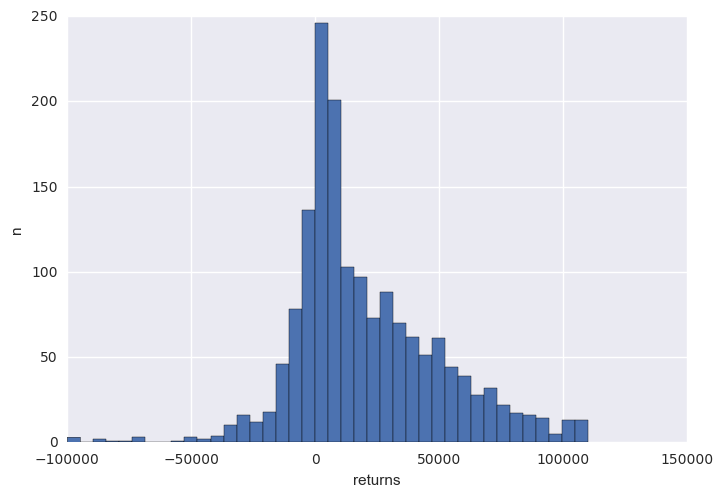

Made losses in 2016 = 21%


In [49]:
def reject_outliers(data, m=0.1):
    return data[abs(data - np.mean(data)) < m * np.std(data)]
reject_outliers(df['returns']).hist(bins=40)
plt.ylabel('n')
plt.xlabel('returns')
plt.show()

losses = (df['returns']<0).sum()
N = df.shape[0]
print("Made losses in 2016 = {:.0%}".format((losses/N)))

Still, we can say that 1/5th of people buying and selling properties in 2016 made a loss doing so. But house prices always go up, right?

### 1.3.1 Returns by type

I'm also interested in whether the type (i.e., detatched, semi, flat or terraced) of property sold has an effect on returns.

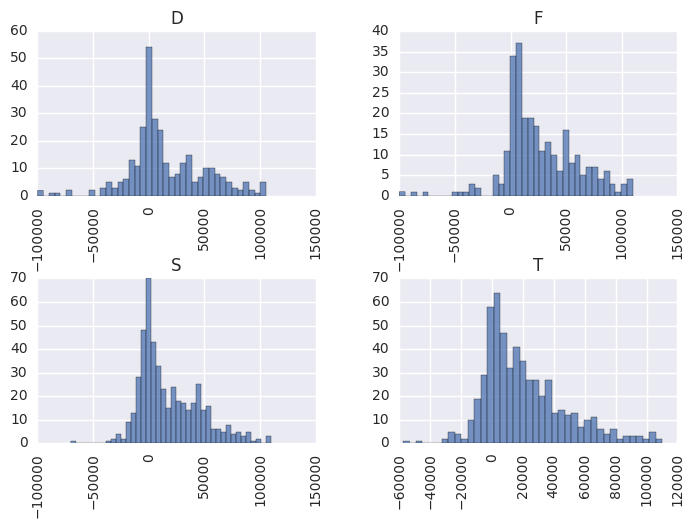

For type: D - 29% made losses in 2016
For type: F - 11% made losses in 2016
For type: S - 26% made losses in 2016
For type: T - 17% made losses in 2016


In [50]:
df = df[df['type'] != 'O'] # there are very few samples of 'other' type properties to warrent inclusion

reject_outliers(df['returns']).hist(by=df['type'],bins=40,alpha=0.75)
plt.show()

grouped = df.groupby('type')

for index, group in grouped:
    losses = (group.returns<0).sum()
    N = group.returns.shape[0]
    print("For type:",index,"- {:.0%} made losses in 2016".format((losses/N)))

Interestingly, Detached and Semi-Detached properties performed the worst. I was actually expecting flats to do worse.

Returns are not the only way of measuring performance. In the next part of this series, I will be looking at a more sifisticated measure called alpha ($\alpha$) that shows the *relative* performance of an asset compared the a market benchmark.